In [1]:
import pysam
import pandas as pd
import pyBigWig
import hdbscan
import networkx as nx
import numpy as np
import bioframe as bf
import statsmodels.api as sm
from scipy.stats import t
import matplotlib.pyplot as plt
import os

In [3]:
def perform_HDBScan_clustering(read_tbl,min_cluster,processes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster,
                        metric='euclidean',
                        core_dist_n_jobs=processes)
    clusterer.fit(read_tbl.loc[:,['start']])

def collect_hdb_cluster_read(g):
    
    leaves = set([v for v, d in g.out_degree() if d == 0])
    HDB_clusters = [v for v, d in g.out_degree() if d > 0]

    cl_read_idx = [list(nx.descendants(g,i).intersection(leaves)) for i in HDB_clusters]
    cl_read_tbl = pd.DataFrame({"HDB_cluster":HDB_clusters,"read_id_set":cl_read_idx})
    return(cl_read_tbl)



In [4]:
def build_hic_zscore(data_tbl,vars,vars_df,vars_degree,target_var):
    """
        Computes statistical values (z-scores and p-values) for a given dataset using a smoothing model.

        This function applies a Generalized Additive Model (GAM) with B-splines to analyze the relationship
        between selected variables and a target variable. It returns the original dataset with two additional
        columns: 
        - `zscore`: A measure of how much each data point deviates from the average.
        - `pvalue`: A value indicating the significance of each data point.

        Parameters:
        -----------
        data_tbl : pandas.DataFrame
            The dataset containing the variables to be analyzed.
        
        vars : list of str
            The names of the columns to be used as predictors (independent variables).
        
        vars_df : int
            The number of degrees of freedom for the spline smoothing.
        
        vars_degree : int
            The degree of the spline function, which controls how smooth the curve is.
        
        target_var : str
            The column name of the target variable (dependent variable) being analyzed.

        Returns:
        --------
        pandas.DataFrame
            The original dataset with two additional columns:
            - `zscore`: The standardized residuals (how different each value is from the model's prediction).
            - `pvalue`: A probability score indicating the significance of each data point.
        
        Example:
        --------
        Suppose `data_tbl` contains genetic data, where `vars` represents different genetic markers, 
        and `target_var` is a measure of gene expression. This function helps determine which data 
        points significantly deviate from the expected pattern.
    """
    x_spline = data_tbl[vars].to_numpy(dtype=float)
    y = data_tbl[target_var].to_numpy(dtype=float)
    bs = sm.gam.BSplines(x_spline, df=vars_df, degree=vars_degree)

    chr_gam = sm.GLMGam(y,smoother=bs)
    chr_gam_res = chr_gam.fit()
    gam_infl = chr_gam_res.get_influence()
    bs_tranform_exog = bs.transform(data_tbl[vars].to_numpy())
    tmp_rng = chr_gam_res.get_distribution(exog=bs_tranform_exog)
    mod_pvalue = tmp_rng.sf(data_tbl[target_var].to_numpy())
    new_data_tbl = data_tbl.assign(zscore = gam_infl.resid_studentized,pvalue = mod_pvalue)
    return new_data_tbl


In [5]:
ctrl_bam = "./../data/CTCF/bam/CTCF_ctrl_MCF7_ENCFF806IOU.bam"
obs_bam = "./../data/CTCF/bam/CTCF_obs_MCF7_ENCFF623IZG.bam"
pvalue_bw_file = "./../data/CTCF/bigwig/CTCF_pvalue_MCF7_ENCFF767VZW.bigWig"
peak_bed_file = "./../data/CTCF/bed/CTCF_peak_MCF7_rep1_ENCFF167NKR.bed"

In [6]:
ctrl_bamfile = pysam.AlignmentFile(ctrl_bam, "rb")
obs_bamfile = pysam.AlignmentFile(obs_bam, "rb")
pvalue_bw = pyBigWig.open(pvalue_bw_file)

[W::hts_idx_load3] The index file is older than the data file: /storage/mathelierarea/processed/vipin/group/scripts/TFHclust/TFHclust/data/CHD1/bam/CHD1_ctrl_MCF7_ENCFF612QJN.bai
[W::hts_idx_load3] The index file is older than the data file: /storage/mathelierarea/processed/vipin/group/scripts/TFHclust/TFHclust/data/CHD1/bam/CHD1_obs_MCF7_ENCFF308MMO.bai


In [7]:
peak_df = (pd.read_csv(peak_bed_file,sep="\t",header=None,usecols=[0,1,2,3,4])
 .rename(columns={0:'chrom',1:'start',2:'end',3:'ID',4:'IDR'})
 )

In [8]:
chromo = "chr22"

In [9]:
ctrl_iter = ctrl_bamfile.fetch(chromo)
obs_iter = obs_bamfile.fetch(chromo)

In [10]:
ctrl_dfs = []
for ix in ctrl_iter:
    ctrl_dfs.append(pd.DataFrame({'ID':[ix.to_dict()['name']],'chrom':[ix.to_dict()['ref_name']],'start':[ix.to_dict()['ref_pos']],'flag':[ix.to_dict()['flag']]}))

In [11]:
obs_dfs = []
for ix in obs_iter:
    obs_dfs.append(pd.DataFrame({'ID':[ix.to_dict()['name']],'chrom':[ix.to_dict()['ref_name']],'start':[ix.to_dict()['ref_pos']],'flag':[ix.to_dict()['flag']]}))

In [12]:
bg_df = pd.concat(ctrl_dfs).assign(start = lambda df_: df_.start.astype(int))
read_tbl = pd.concat(obs_dfs).assign(start = lambda df_: df_.start.astype(int))

In [13]:
read_tbl.flag.value_counts()

flag
16    97347
0     96952
Name: count, dtype: int64

In [14]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3,
                    metric='euclidean',
                    core_dist_n_jobs=10)
clusterer.fit(read_tbl.loc[:,['start']])
full_graph = clusterer.condensed_tree_.to_networkx()


/div/pythagoras/u5/vipink/.conda/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/div/pythagoras/u5/vipink/.conda/envs/TFHclust/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x7fd776187740>
Traceback (most recent call last):
  File "/div/pythagoras/u5/vipink/.conda/envs/TFHclust/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/div/pythagoras/u5/vipink/.conda/envs/TFHclust/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/div/pythagoras/u5/vipink/.conda/envs/TFHclust/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child p

In [15]:
tmp_cl_tbl = collect_hdb_cluster_read(full_graph)

In [16]:
long_cl_read_tbl = tmp_cl_tbl.explode('read_id_set')
long_cl_read_tbl = (long_cl_read_tbl
                    .assign(start = lambda df_:read_tbl.reset_index().start.to_numpy()[df_.read_id_set.to_numpy(dtype=int)])
                    )

tmp_chr_hdb_summary_tbl = (long_cl_read_tbl
                                .groupby('HDB_cluster')
                                .agg(start = ('start','min'),
                                     end=('start','max'),
                                     rc = ('start','count')
                                    )
                                .assign(w= lambda df_:df_.end - df_.start)
                            )        


In [17]:
tmp_chr_hdb_summary_tbl = tmp_chr_hdb_summary_tbl.reset_index().merge(tmp_cl_tbl)

In [18]:
bg_coord_df = bg_df.loc[:,['chrom','start']].assign(start = lambda df_: df_.start.astype(int)).assign(end = lambda df_: df_.start + 1)

In [19]:
hdb_cluster_bg_rc_df = bf.count_overlaps(tmp_chr_hdb_summary_tbl.assign(chrom = chromo).loc[:,['chrom','start','end','HDB_cluster']],bg_coord_df)

<Axes: xlabel='bg_count', ylabel='rc'>

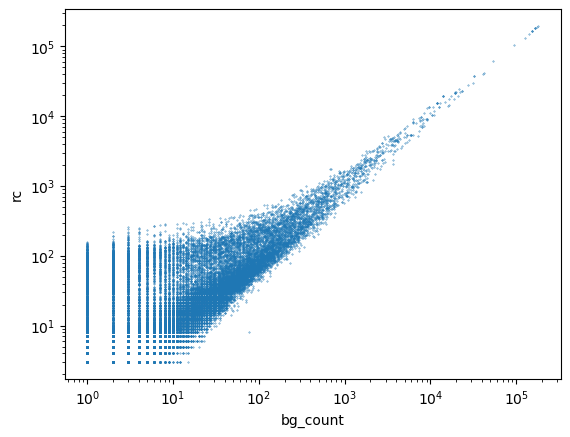

In [20]:
tmp_chr_hdb_summary_tbl.merge(hdb_cluster_bg_rc_df.rename(columns={'count':'bg_count'})).plot.scatter(x='bg_count',y='rc',s=0.1,logx=True,logy=True)

In [21]:
tmp_chr_hdb_summary_tbl = tmp_chr_hdb_summary_tbl.merge(hdb_cluster_bg_rc_df.rename(columns={'count':'bg_count'}))

In [22]:
data_tbl = (tmp_chr_hdb_summary_tbl
            .loc[:,['HDB_cluster','rc','bg_count']]
            .assign(lrc = lambda df_: np.log10(df_.rc), lbg = lambda df_: np.log10(df_.bg_count))
            .assign(lbg2 = lambda df_: np.where(df_.bg_count.lt(1),0,df_.lbg))
            )

/div/pythagoras/u5/vipink/.conda/envs/TFHclust/lib/python3.12/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)


In [23]:
mod_res_tbl = build_hic_zscore(data_tbl,['lbg2'],[10],[3],'lrc')

In [24]:
data_tbl = data_tbl.merge(mod_res_tbl)

<Axes: xlabel='lbg2', ylabel='lrc'>

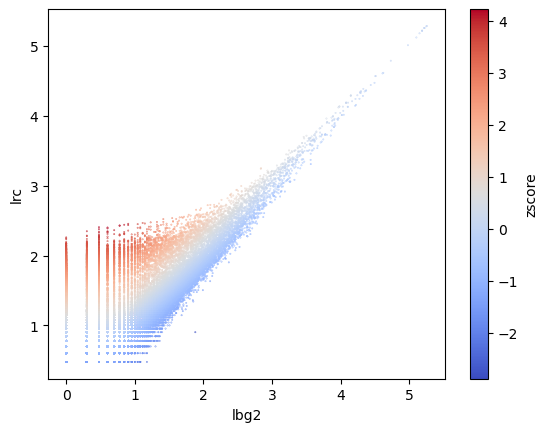

In [25]:
data_tbl.sort_values('zscore').plot.scatter(x='lbg2',y='lrc',c='zscore',s=0.1,cmap='coolwarm')

In [27]:
cl_summary_tbl =  (data_tbl
                    .merge(tmp_chr_hdb_summary_tbl.loc[:,['HDB_cluster','chrom','start','end','w']])
                    .assign(MACS_pvalue = lambda df_: df_.apply(lambda row: pvalue_bw.stats(row.chrom,row.start,row.end,type="mean")[0],axis=1))
                    .assign(FC = lambda df_: (df_.rc/df_.w)/((df_.bg_count+1)/df_.w))
                  )


<Axes: ylabel='Density'>

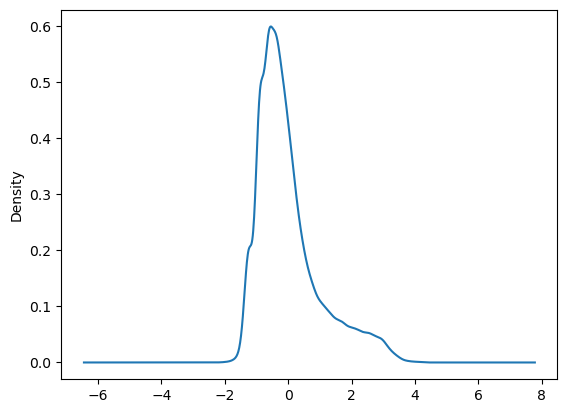

In [29]:
(cl_summary_tbl
 .zscore.plot.kde()
)

<Axes: xlabel='zscore', ylabel='obs_rd'>

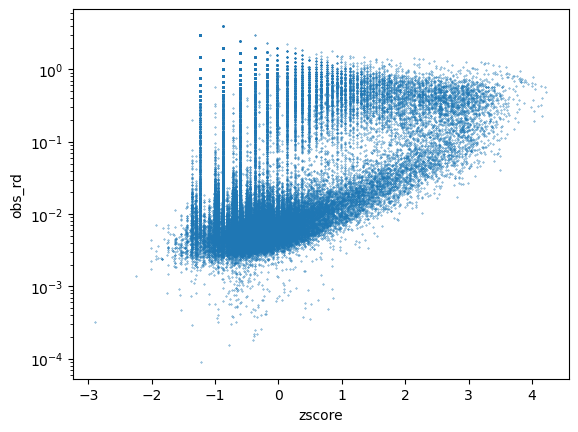

In [ ]:
(cl_summary_tbl
 .assign(obs_rd = lambda df_: (df_.rc/df_.w))
 .plot.scatter(x='zscore',y='obs_rd',s=0.1,logy=True)
 )

<Axes: xlabel='zscore', ylabel='FC'>

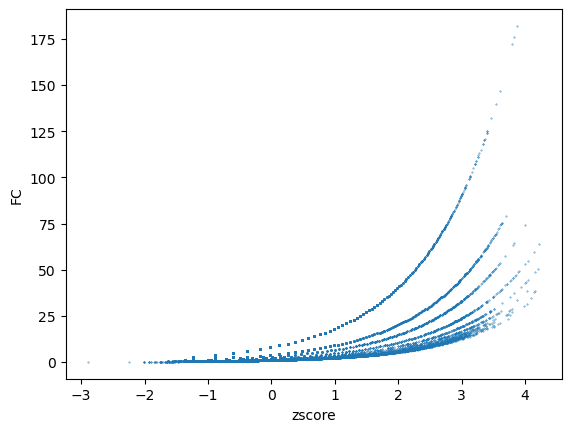

In [31]:
(cl_summary_tbl
.plot.scatter(x='zscore',y='FC',s=0.1)
 )

<Axes: xlabel='FC', ylabel='MACS_pvalue'>

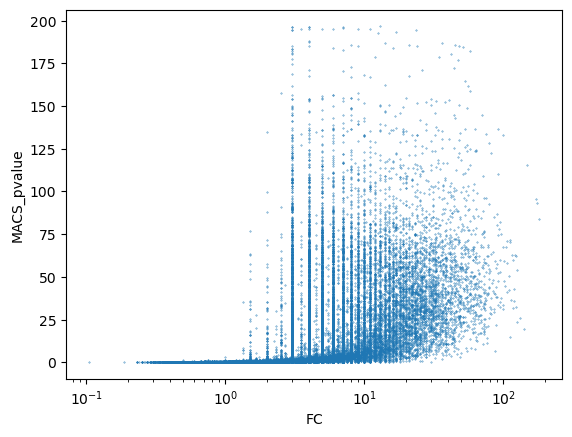

In [33]:
(cl_summary_tbl
 .plot.scatter(x='FC',y='MACS_pvalue',s=0.1,logx=True)
)

<Axes: xlabel='zscore', ylabel='MACS_pvalue'>

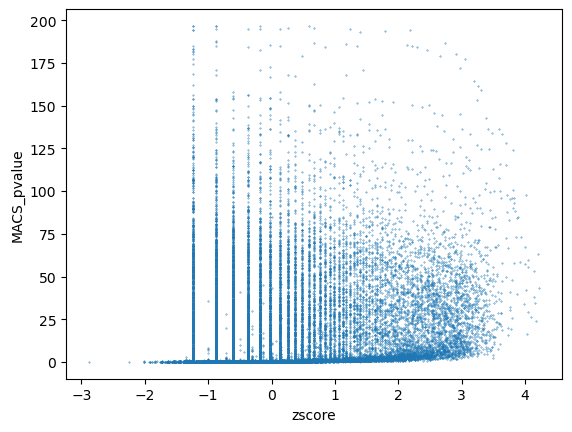

In [32]:
(cl_summary_tbl
 .plot.scatter(x='zscore',y='MACS_pvalue',s=0.1)
)

<Axes: xlabel='zscore', ylabel='pvalue'>

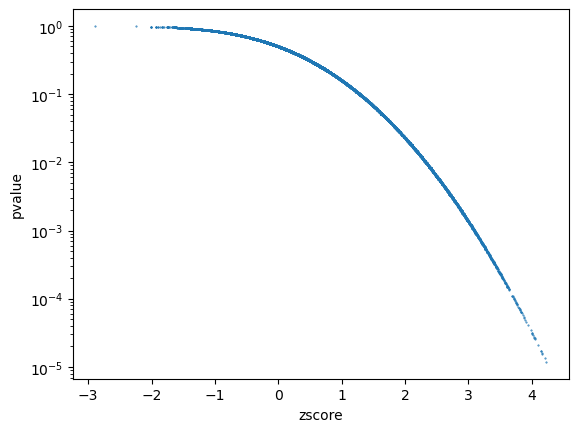

In [33]:
(cl_summary_tbl
 .plot
 .scatter(x='zscore',y='pvalue',logy=True,s=0.2)
)

<Axes: xlabel='lp', ylabel='MACS_pvalue'>

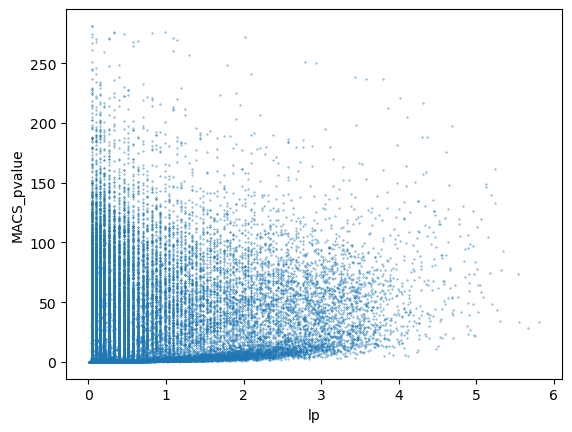

In [26]:
cl_summary_tbl.assign(lp = lambda df_: -np.log10(df_.pvalue)).plot.scatter(x='lp',y='MACS_pvalue',s=0.1)

<Axes: xlabel='pvalue', ylabel='rd'>

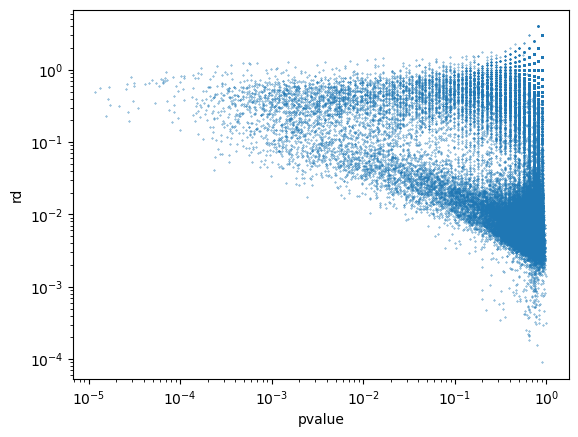

In [36]:
cl_summary_tbl.assign(rd = lambda df_: df_.rc/df_.w).plot.scatter(x='pvalue',y='rd',logx=True,logy=True,s=0.1)

<Axes: ylabel='Density'>

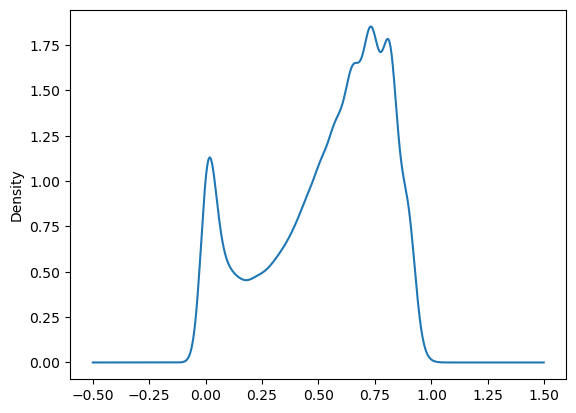

In [37]:
cl_summary_tbl.pvalue.plot.kde()

In [38]:
smooth_window = 150
obs_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':read_tbl.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':read_tbl.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()

bg_rcount_bdg = pd.concat([pd.DataFrame({'DNA_pos':bg_df.start.to_numpy() }).assign(score = 1),
                             pd.DataFrame({'DNA_pos':bg_df.start.to_numpy() + smooth_window}).assign(score = -1)
                            ]).sort_values('DNA_pos').assign(csum = lambda df_: df_.score.cumsum()).groupby('DNA_pos').agg(rcount = ('csum','max')).reset_index()


In [39]:
obs_rcount_bdg = obs_rcount_bdg.assign(rd = lambda df_: df_.rcount/read_tbl.shape[0])
bg_rcount_bdg =bg_rcount_bdg.assign(rd = lambda df_: df_.rcount/bg_df.shape[0])

In [40]:
candidate_clusters_df = cl_summary_tbl.query("pvalue <0.05 ")

In [41]:
candidate_clusters_list = candidate_clusters_df.HDB_cluster.drop_duplicates().to_list()

In [42]:
cl_root_indicator = [len(set((nx.ancestors(full_graph,i))).intersection(candidate_clusters_list)) < 1 for i in candidate_clusters_list]


In [43]:
root_candidate_cl_list = pd.DataFrame({'HDB_cluster':candidate_clusters_list, 'is_root':cl_root_indicator}).query('is_root').HDB_cluster.to_list()

In [44]:
def get_cl_lvl(tmp_root,candidate_clusters_list,full_graph):
    node_depth = nx.shortest_path_length(full_graph,source=tmp_root)
    tmp_cl_list = list(set(node_depth.keys()).intersection(candidate_clusters_list))

    return pd.DataFrame({'HDB_cluster':tmp_cl_list,'lvl':[node_depth[i] for i in tmp_cl_list]})    


In [45]:
candidate_clusters_df = candidate_clusters_df.merge(pd.concat([get_cl_lvl(i,candidate_clusters_list,full_graph) for i in root_candidate_cl_list]))

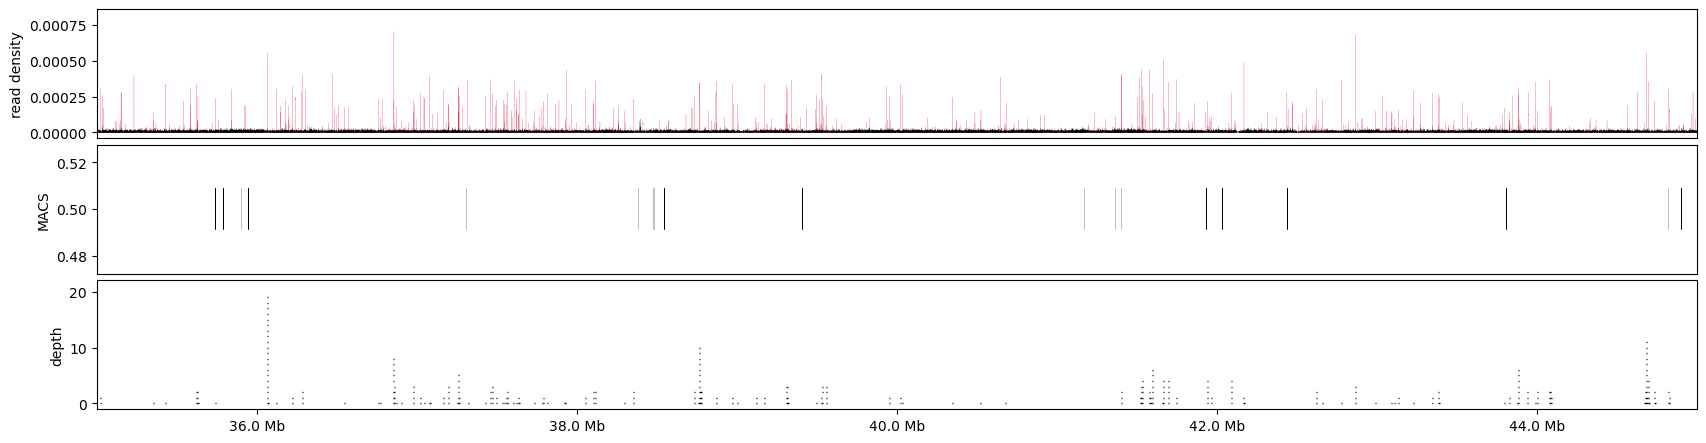

In [47]:
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(3, 1, height_ratios=(1, 1, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# plot_window_min = obs_rcount_bdg.DNA_pos.min()
# plot_window_max = obs_rcount_bdg.DNA_pos.max()

plot_window_min = 35_000_000				 
plot_window_max = 45_000_000

ax_dens = fig.add_subplot(gs[0, 0],xlim = (plot_window_min,plot_window_max) )
ax_dens.xaxis.set_visible(False)
# ax_dens.set_yscale('log')
ax_dens.set_ylabel('read density')

ax_agg = fig.add_subplot(gs[1, 0],sharex=ax_dens)
ax_agg.xaxis.set_major_formatter(lambda x,pos: (str(np.round(x/1e6,decimals=2)) + " Mb"))
ax_agg.xaxis.set_visible(False)
ax_agg.set_ylabel('MACS')

ax_cl = fig.add_subplot(gs[2, 0],sharex=ax_dens)
ax_cl.xaxis.set_major_formatter(lambda x,pos: (str(np.round(x/1e6,decimals=2)) + " Mb"))
ax_cl.xaxis.set_visible(True)
ax_cl.set_ylabel('depth')

for bin_idx in range(candidate_clusters_df.shape[0]):
    tmp_cl =  candidate_clusters_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    tmp_h = tmp_cl.lvl
    ax_cl.hlines(y=tmp_h,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=1)

tmp_peak_df = bf.merge(peak_df.query('chrom == "chr19"'))
for bin_idx in range(tmp_peak_df.shape[0]):
    tmp_cl =  tmp_peak_df.iloc[bin_idx,:]
    tmp_start = tmp_cl.start
    tmp_end = tmp_cl.end 
    # tmp_h = tmp_cl.n_intervals
    if bin_idx %2 == 0:
        ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='black',linewidth=30)
    else:
        ax_agg.hlines(y=0.5,xmin=tmp_start,xmax=tmp_end,color='silver',linewidth=30)
ax_dens.step(x=obs_rcount_bdg.DNA_pos.to_numpy(),y=obs_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='crimson')
ax_dens.step(x=bg_rcount_bdg.DNA_pos.to_numpy(),y=bg_rcount_bdg.rd.to_numpy(),where='post',linewidth=0.1,alpha=1,c='black')


In [37]:
cl_summary_tbl.pvalue.min()

1.5346167998754096e-06

In [38]:
(bf.count_overlaps(peak_df.query("chrom == 'chr19'") ,cl_summary_tbl.loc[:,['chrom','start','end','HDB_cluster','zscore','pvalue']].query("pvalue < 0.05"))
 .assign(out_HDB = lambda df_: df_.loc[:,'count'].lt(1),lIDR = lambda df_: np.log10(df_.IDR))
 .groupby('out_HDB').IDR.mean()
 )

out_HDB
False    980.610144
True     787.330769
Name: IDR, dtype: float64

In [39]:
cl_summary_tbl.sort_values('rc',ascending = False)

,HDB_cluster,rc,bg_count,lrc,lbg,lbg2,zscore,pvalue,chrom,start,end,w,MACS_pvalue,FC
0,352101,352101,375438,5.546667,5.574538,5.574538,-0.176768,0.566265,chr19,89241,58607366,58518125,0.478198,0.937838
1,352102,219426,237715,5.341288,5.376057,5.376057,-0.160535,0.561494,chr19,27242667,58607366,31364699,0.508367,0.923059
3,352104,166182,175863,5.220584,5.245174,5.245174,-0.104185,0.540391,chr19,27242667,50103567,22860900,0.527037,0.944946
2,352103,132675,137714,5.122789,5.138978,5.138978,-0.059608,0.523278,chr19,89241,24908105,24818864,0.457547,0.963403
5,352106,132639,137646,5.122671,5.138764,5.138764,-0.059263,0.523143,chr19,89241,24435999,24346758,0.460749,0.963617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75181,427282,3,0,0.477121,-inf,0.000000,-1.271333,0.898190,chr19,10856859,10857093,234,0.439942,3.0
64980,417081,3,0,0.477121,-inf,0.000000,-1.271333,0.898190,chr19,45493607,45493610,3,15.523387,3.0
83187,435288,3,0,0.477121,-inf,0.000000,-1.271333,0.898190,chr19,16247704,16247707,3,38.140305,3.0
75187,427288,3,0,0.477121,-inf,0.000000,-1.271333,0.898190,chr19,10942176,10942179,3,102.060771,3.0


In [41]:
node_depth = nx.shortest_path_length(full_graph,source=352101)


In [42]:
cl_summary_tbl = cl_summary_tbl.assign(lvl = lambda df_:[node_depth[i] for i in df_.HDB_cluster])

<Axes: xlabel='lvl', ylabel='zscore'>

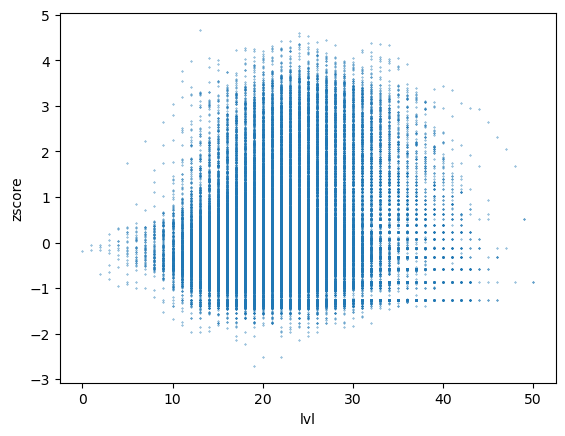

In [43]:
cl_summary_tbl.plot.scatter(x='lvl',y ='zscore',logy=False,s=0.1)

In [50]:
bf.count_overlaps(cl_summary_tbl.query("HDB_cluster in @root_candidate_cl_list"),peak_df).sort_values('count')

,HDB_cluster,rc,bg_count,lrc,lbg,lbg2,zscore,pvalue,chrom,start,end,w,MACS_pvalue,FC,lvl,count
0,352124,27,1,1.431364,0.0,0.000000,1.740037,0.040929,chr19,47941361,47941382,21,15.475893,13.5,5,0
189,362263,35,12,1.544068,1.079181,1.079181,1.317764,0.093799,chr19,56300508,56302074,1566,1.718141,2.692308,19,0
200,363049,28,4,1.447158,0.60206,0.602060,1.761350,0.039097,chr19,30124589,30125305,716,2.785858,5.6,14,0
1005,405632,24,7,1.380211,0.845098,0.845098,1.305004,0.095953,chr19,22143799,22145603,1804,0.679495,3.0,25,0
228,364115,30,10,1.477121,1.0,1.000000,1.297215,0.097288,chr19,50499638,50502044,2406,0.937907,2.727273,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,405353,643,276,2.808211,2.440909,2.440909,1.288817,0.098747,chr19,18382629,18424889,42260,1.331799,2.3213,27,5
434,373436,810,342,2.908485,2.534026,2.534026,1.317971,0.093775,chr19,14027460,14084963,57503,1.446476,2.361516,17,5
240,364790,430,175,2.633468,2.243038,2.243038,1.344636,0.089384,chr19,1236277,1287404,51127,0.863912,2.443182,15,5
370,370163,621,238,2.793092,2.376577,2.376577,1.439031,0.075084,chr19,4184164,4225465,41301,1.684560,2.598326,19,6


In [54]:
peak_df.chrom.value_counts()

chrom
chr1     4356
chr2     3838
chr3     3337
chr5     2797
chr7     2771
chr6     2431
chr12    2428
chr8     2332
chr11    2300
chr4     2287
chr10    2215
chr17    2150
chr9     2049
chr14    1872
chrX     1694
chr20    1681
chr15    1585
chr19    1581
chr16    1569
chr13    1041
chr18     824
chr22     775
chr21     566
Name: count, dtype: int64